# Word2Vec for The ONS 
The purpose of this notebook is to demonstrate how we can use [word2vec](https://www.tensorflow.org/tutorials/word2vec) to bridge the gap between the way the ONS and the general public communicate. This is a common problem seen when users search the website for terms such as 'murder', as the ONS publishes such content under the more professional term 'homicide'.

By using training data such as the Google News vocabulary dataset, we can train models to understand the relationship between words in a 300-dimensional vector space, where similar words occupy the same part of this vector space. Here, we use a slimlined version of the Google News dataset for English words only, and import the data using the gensim python module as below:

In [1]:
import gensim

fname = "/Users/sullid/ONS/dp-search-service/src/main/resources/vectorModels/GoogleNews-vectors-negative300-SLIM.bin"
model = gensim.models.KeyedVectors.load_word2vec_format(fname, binary=True)

The next step is to define a set of phrases which are commonly used to search on the ONS website. The below list of 17 words correspond to some of the most popular search terms as recorded by Google Analytics just before Christmas. For each term, we use word2vec to get the 20 most similar words, or the nearst 20 neighbours in our vector space, and append them to a list.

In [2]:
# Collect the word vectors
import numpy as np

searchTerms = ["gender pay gap", "cpi", "gdp", "inflation", "crime", "unemployment", 
              "population", "immigration", "mental health", "london", "life expectancy",
              "obesity", "religion", "migration", "poverty", "social media", "employment"]

def getVectorsAndWords(term, topn=20):
    vectors = []
    terms = []
    
    term= term.lower()
    
    vec = model.word_vec(term)
    vectors.append(vec)
    terms.append(term)
    
    # Add similar words
    for word,score in model.similar_by_word(term, topn=topn):
        word = word.lower()
        if (score > 0.5 and word.lower() not in words):
            vec = model.word_vec(word.lower())
            vectors.append(vec)
            terms.append(word)
            
    return vectors, terms

topn = 100
word_vectors = []
words = []
for searchTerm in searchTerms:
    try:
        if (len(searchTerm.split(" ")) > 1):
            parts = searchTerm.split(" ")
            for part in parts:
                vectors, terms = getVectorsAndWords(part, topn=topn)
                word_vectors.extend(vectors)
                words.extend(terms)
        else:
            vectors, terms = getVectorsAndWords(searchTerm, topn=topn)
            word_vectors.extend(vectors)
            words.extend(terms)
    except KeyError:
        pass
word_vectors = np.array(word_vectors)

# word_vectors = model.wv.syn0
n_words = word_vectors.shape[0]
vec_size = word_vectors.shape[1]

In [3]:
print "Got %d words in total" % (n_words)

Got 309 words in total


# PCA
In order to visualise the relationship between this set of words, we have to reduce our 300 dimensional vector space down to the two or three dimensions we are typically use to visualizing. To do this, we use a technique called *Principal Component Analysis*, or *PCA*. This is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. It should be noted, that the definition of each principal component is not (and need not be) necessarily well understood, as each component can in principle describe the relationship between many others. Below, we compute the first 3 principal components of our 300-dimensional vector space:

In [4]:
from sklearn import decomposition

dimensions=3
pca = decomposition.PCA(n_components=dimensions)
pca_fit = pca.fit(word_vectors)

vectors = pca_fit.transform(word_vectors)
print vectors.shape

(309, 3)


# Clustering
Now that we have reduced the dimensionality of our data, we can proceed to group words into *clusters* of similarity. As we don't know the number of such clustera *a priori*, we can use the *elbow* method to determine the minimum number of clusters present in our data, by plotting the number of clusters against the percentage of variance explained:

Performing K-Means...
Done
Computing Euclidean distances...
Done
Computing pairwise distances...
Computing percentage of variance explained...
Plotting...
Minimum number of clusters =  4


/Users/sullid/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning:

invalid value encountered in greater



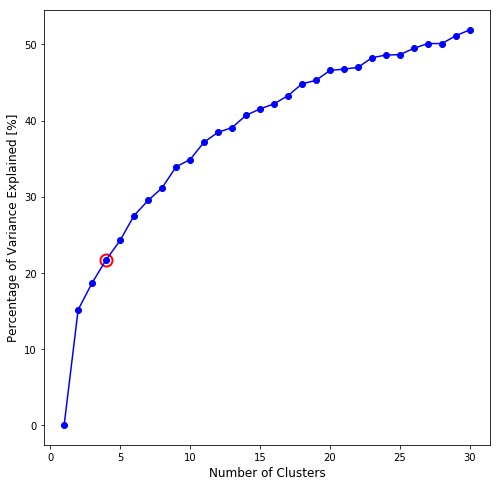

In [29]:
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import fclusterdata

def eblow(data, n):
    print "Performing K-Means..."
    kMeansVar = [KMeans(n_clusters=k, random_state=0).fit(data) for k in range(1, n)]
    print "Done"
    centroids = [X.cluster_centers_ for X in kMeansVar]
    print "Computing Euclidean distances..."
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    print "Done"
    wcss = [sum(d**2) for d in dist]
    print "Computing pairwise distances..."
    pair_dist = pdist(data)
    print "Computing percentage of variance explained..."
    tss = sum(pair_dist**2)/data.shape[0]
    bss = tss - wcss
    percentage_variance = (bss/tss)*100.0
    
    K = range(1,n)
    seg_threshold = 0.95 #Set this to your desired target

    #The angle between three points
    def segments_gain(p1, v, p2):
        vp1 = np.linalg.norm(p1 - v)
        vp2 = np.linalg.norm(p2 - v)
        p1p2 = np.linalg.norm(p1 - p2)
        return np.arccos((vp1**2 + vp2**2 - p1p2**2) / (2 * vp1 * vp2)) / np.pi

    #Normalize the data
    criterion = np.array(avgWithinSS)
    criterion = (criterion - criterion.min()) / (criterion.max() - criterion.min())

    #Compute the angles
    seg_gains = np.array([0, ] + [segments_gain(*
            [np.array([K[j], criterion[j]]) for j in range(i-1, i+2)]
        ) for i in range(len(K) - 2)] + [np.nan, ])

    #Get the first index satisfying the threshold
    kIdx = np.argmax(seg_gains > seg_threshold)
    
    print "Plotting..."
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(K[kIdx], percentage_variance[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    
    ax.scatter(K, percentage_variance, color='b')
    ax.plot(K, percentage_variance, color='b')
    
    ax.set_xlabel("Number of Clusters", fontsize=12)
    ax.set_ylabel("Percentage of Variance Explained [%]", fontsize=12)
    
    print "Minimum number of clusters = ", K[kIdx]
    
    return kMeansVar
    
kMeansVar = eblow(word_vectors, 31)
plt.show()

# Visualization
First, lets plot the results in 2D. To do this, we perform *PCA* with 2 dimensions only, and plot the reslting words in this 2 dimensional vector space. Here, we use colour to distinguish different clusters from one another.

In [7]:
import scipy.cluster.hierarchy as hcluster
import re
import nltk

def ncols(n, cmap='rainbow'):
    import matplotlib.pylab as plt
    cmap = plt.get_cmap(cmap)
    return cmap(np.linspace(0, 1, n))

class SemanticMap:
    def __init__(self, model):
        self.model = model

    def __split_words(self, input_string):
        return re.findall(r"[\w']+", input_string)

    def __clean_words(self, words):
        clean_words = []
        for w in words:
            clean_words.append(re.sub(r'\W+', '', w.lower()))
        return clean_words

    def __remove_stop_words(self, words):
        return [w for w in words if not w in nltk.corpus.stopwords.words('english')]

    def __get_non_compositional_entity_vector(self, entity):
        return self.model[entity[0]]

    def __get_compositional_entity_vector(self, entity):
        array = np.array(self.model[entity[0]])
        for ind in range (1, len(entity)):
            array = array + np.array(self.model[entity[ind]])
        return array/len(entity)

    def __get_vector(self, term):
        words = self.__remove_stop_words(self.__clean_words(self.__split_words(term)))

        if len(words) < 1:
            print 'All the terms have been filtered.'
            raise
        if len(words) == 1:
            try:
                return self.__get_non_compositional_entity_vector(words)
            except:
                print 'Out-of-vocabulary entity'
                raise
        elif len(words) < 4:
            try:
                return self.__get_compositional_entity_vector(words)
            except:
                print 'Out-of-vocabulary word in compositional entity'
                raise
        else:
            print 'Entity is too long.'
            raise

    def __reduce_dimensionality(self, word_vectors, dimension=2):
        data = np.array(word_vectors)
        pca = decomposition.PCA(n_components=dimension)
        pca.fit(data)
        return pca.transform(data)

    def cluster_results(self, data, threshold=0.13):
        return hcluster.fclusterdata(data, threshold, criterion="distance")

    def map_words(self, words, sizes):
        final_words = []
        final_sizes = []
        vectors = []

        for word in words:
            try:
                vect = self.__get_vector(word)
                vectors.append(vect)
                if sizes is not None:
                    final_sizes.append(sizes[words.index(word)])
                final_words.append(word)
            except Exception as e:
                print 'not valid ' + word, e

        return vectors, final_words, final_sizes

    def plot(self, vectors, lemmas, clusters, kOpt, vector_idx, figsize, sizes=80):
        fig,ax = plt.subplots(figsize=(12,12))
        if sizes == []:
            sizes = 80
        ax.scatter(vectors[:, 0], vectors[:, 1], s=sizes, c=clusters)
        
        print kOpt
        cols = ncols(kOpt)
        for kn in range(kOpt):
            for label, x, y in zip(lemmas, vectors[:, 0], vectors[:, 1]):
                ix = lemmas.index(label)
                if (vector_idx[ix] == kn):
                    ax.annotate(
                        label,
                        xy = (x, y), xytext = (-20, 20),
                        textcoords = 'offset points', ha = 'right', va = 'bottom',
                        bbox = dict(boxstyle = 'round,pad=0.5', fc = cols[kn], alpha = 0.25),
                        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

        plt.show()

    def map_cluster_plot(self, words, sizes, threshold, kOpt, vector_idx, figsize=(8,8)):
        vectors, words, sizes = self.map_words(words, sizes)
        vectors = self.__reduce_dimensionality(vectors)
        clusters = self.cluster_results(vectors, threshold)
        self.plot(vectors, words, clusters, kOpt, vector_idx, figsize, sizes=sizes)

    def print_results(self, words, clusters):
        print words
        print clusters.tolist()

10


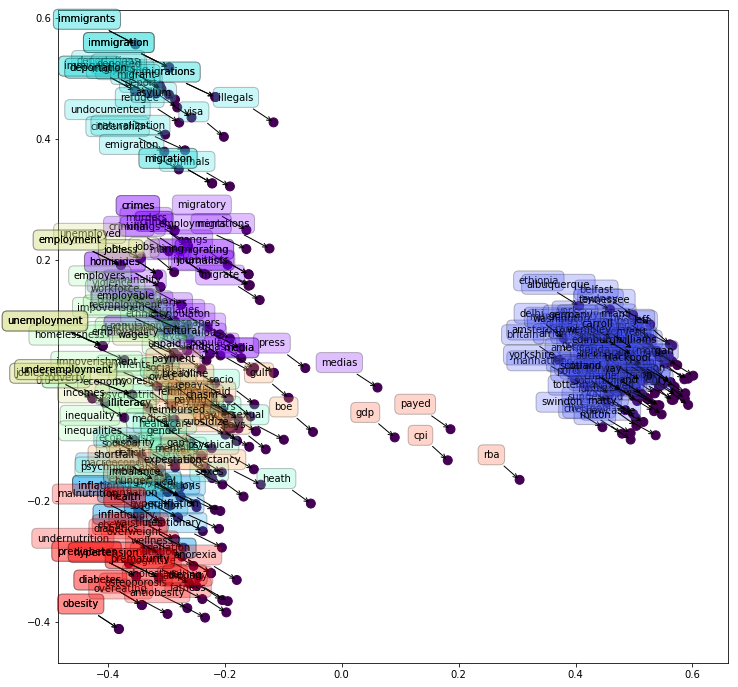

In [8]:
kOpt=10
kMeansClusterVar = kMeansVar[kOpt-1]
vector_idx = kMeansClusterVar.fit_predict(vectors)

semantic_map = SemanticMap(model)
semantic_map.map_cluster_plot(words, None, 0.2, kOpt, vector_idx, figsize=(18,18))

# Adding a Dimension
As we can see, this plot becomes increasingly difficult to interpret for large numbers of words. To improve on this, we can go one step further and make the same plot but in 3D:

In [10]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = map(np.uint8, np.array(cmap(k*h)[:3])*255)
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

In [28]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])
scene = dict(
    camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.1, z=0.1)
    ),
    xaxis=dict(title='pc1',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(title='pc2',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(title='pc3',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

kOpt = 10
pca3 = decomposition.PCA(n_components=3)
pca_fit3 = pca.fit(word_vectors)
X = pca_fit3.transform(word_vectors)

name,est = ('k_means', KMeans(n_clusters=kOpt, random_state=0).fit(word_vectors))
vector_idx = est.fit_predict(X)

cols = ncols(kOpt+1, cmap="Set3")
for icluster in range(kOpt):
    idx = np.where(vector_idx == icluster)[0]
    labels = est.labels_[idx]
    data = X[idx]
    
    text = [words[ix] for ix in idx]
    pcols = [cols[icluster]] * len(idx)

    trace = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2],
                         name="Cluster %d" % (icluster + 1),
                         text=text,
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                color=pcols[:],
                                line=dict(color='black', width=1)
        ))
    fig.append_trace(trace, 1, 1)

fig['layout'].update(height=900, width=900,
                     margin=dict(l=10,r=10))

fig['layout']['scene1'].update(scene)
fig['layout']['scene2'].update(scene)
fig['layout']['scene3'].update(scene)
fig['layout']['scene4'].update(scene)
fig['layout']['scene5'].update(scene)

# Use py.iplot() for IPython notebook
py.iplot(fig, filename='3d point clustering')

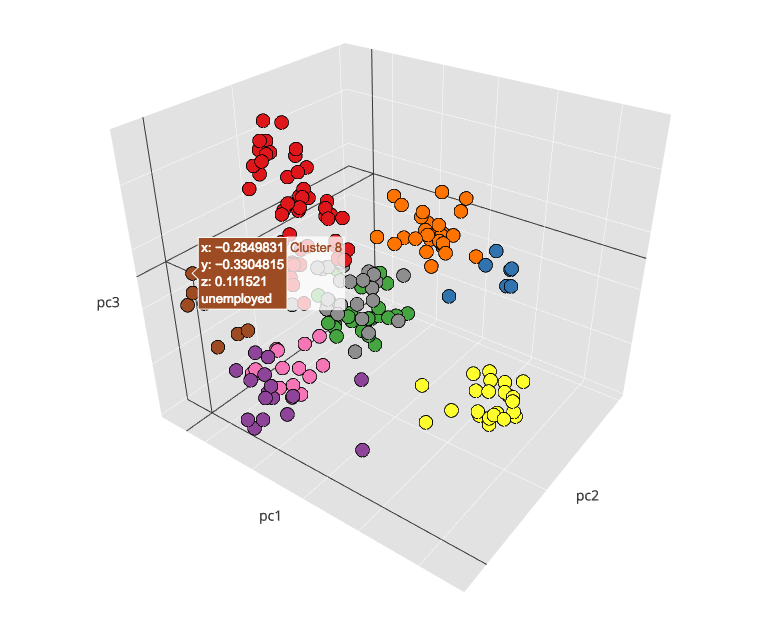

In [362]:
from IPython.display import Image
Image(filename='plots/clusters.png')

# FInal Remarks
We have used *PCA* in this example in order to visualize the data in a way humans are accustom to, however in practice this is not necesarry. In fact, in this example we performed the clustering of our data in the full 300 dimensional vector space, and only reduced the dimensionality of this data in order to visualize groups of similar words.